# Name: YANNIS BOADJI

#### Project: Song Popularity Prediction

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("mode.chained_assignment",None)
pd.options.display.max_rows = 5

## Data Preparation

In [2]:
#Loading Dataset

spotify_dataset = pd.read_csv('../data/data.csv')
display(spotify_dataset)

,Track,Artist,Year,Duration,Time_Signature,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Popularity,Genre
0,Hey Jack Kerouac,"10,000 Maniacs",1987,206413,4,0.616,0.511,6,-15.894,1,0.0279,0.0384,0.000000,0.150,0.604,132.015,40,Alt. Rock
1,Like the Weather,"10,000 Maniacs",1987,236653,4,0.770,0.459,1,-17.453,1,0.0416,0.1120,0.003430,0.145,0.963,133.351,43,Alt. Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15148,Africa Remembers,Youssou N'Dour,2007,560466,4,0.696,0.378,5,-16.181,0,0.0797,0.4440,0.019400,0.085,0.551,97.677,8,World
15149,Wiri-Wiri,Youssou N'Dour,2007,247466,4,0.654,0.516,5,-10.325,1,0.0707,0.3040,0.000235,0.110,0.259,83.013,5,World


In [3]:
#Mapping music genres to numbers and replacing them in the dataset

genres = sorted(list(set(spotify_dataset["Genre"])))

character_to_num = { ch:i for i,ch in enumerate(genres) }
print(character_to_num)

spotify_copy = spotify_dataset.copy()
mask = spotify_copy.loc[:,"Genre"]

for i, ch in enumerate(spotify_copy.loc[:,"Genre"]):
    spotify_copy.loc[:,"Genre"][i] = character_to_num[ch]

#Moving column "Genre" to the previous index for easier splitting
col = spotify_copy.pop('Genre')
spotify_copy.insert(16,col.name,col)

display(spotify_copy)

{'Alt. Rock': 0, 'Blues': 1, 'Country': 2, 'Disco': 3, 'EDM': 4, 'Folk': 5, 'Funk': 6, 'Gospel': 7, 'Jazz': 8, 'Metal': 9, 'Pop': 10, 'Punk': 11, 'R&B': 12, 'Rap': 13, 'Reggae': 14, 'Rock': 15, 'SKA': 16, 'Today': 17, 'World': 18}


,Track,Artist,Year,Duration,Time_Signature,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Genre,Popularity
0,Hey Jack Kerouac,"10,000 Maniacs",1987,206413,4,0.616,0.511,6,-15.894,1,0.0279,0.0384,0.000000,0.150,0.604,132.015,0,40
1,Like the Weather,"10,000 Maniacs",1987,236653,4,0.770,0.459,1,-17.453,1,0.0416,0.1120,0.003430,0.145,0.963,133.351,0,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15148,Africa Remembers,Youssou N'Dour,2007,560466,4,0.696,0.378,5,-16.181,0,0.0797,0.4440,0.019400,0.085,0.551,97.677,18,8
15149,Wiri-Wiri,Youssou N'Dour,2007,247466,4,0.654,0.516,5,-10.325,1,0.0707,0.3040,0.000235,0.110,0.259,83.013,18,5


In [4]:
#Data scaling and Splitting

scaler = StandardScaler()
dataset = spotify_copy.to_numpy()

features = scaler.fit_transform(dataset[-11000:,3:17])
targets = scaler.fit_transform(dataset[-11000:,-1].reshape(11000,1))

train_features = features[-features.shape[0]:-1000]
train_targets = targets[-targets.shape[0]:-1000]
print(train_features.shape,train_targets.shape)

test_features = features[-1000:]
test_targets = targets[-1000:]
print(test_features.shape,test_targets.shape)

(10000, 14) (10000, 1)
(1000, 14) (1000, 1)


## Model Definition

In [5]:
class PopularityMLP(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim, hidden3_dim):
        
        super(PopularityMLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)
        self.layer2 = torch.nn.Linear(hidden1_dim, hidden2_dim) 
        self.layer3 = torch.nn.Linear(hidden2_dim, hidden3_dim) 
        self.layer4 = torch.nn.Linear(hidden3_dim, output_dim) 
        self.activation = torch.nn.Sigmoid()
    
    def forward(self, x):
        
        out1 = torch.nn.functional.relu(self.layer1(x))
        out2 = torch.nn.functional.relu(self.layer2(out1))
        out3 = torch.nn.functional.relu(self.layer3(out2))
        out4 = self.layer4(out3)
        output = self.activation(out4)
        
        return output

class PopularityRegression(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim): 
        
        super(PopularityRegression, self).__init__() 
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x): 
        
        out = self.linear(x)
        output = self.activation(out)
        
        return output

In [6]:
torch.manual_seed(55)

model1 = PopularityMLP(input_dim = 14, output_dim = 1, hidden1_dim = 11, hidden2_dim = 7, hidden3_dim=3)
learning_rate1 = 0.001
epochs = 4
batchsize = 100
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate1)
model1

PopularityMLP(
  (layer1): Linear(in_features=14, out_features=11, bias=True)
  (layer2): Linear(in_features=11, out_features=7, bias=True)
  (layer3): Linear(in_features=7, out_features=3, bias=True)
  (layer4): Linear(in_features=3, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [7]:
model2 = PopularityMLP(input_dim = 14, output_dim = 1, hidden1_dim = 11, hidden2_dim = 7, hidden3_dim=3)
learning_rate2 = 0.001
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate2)
model2

PopularityMLP(
  (layer1): Linear(in_features=14, out_features=11, bias=True)
  (layer2): Linear(in_features=11, out_features=7, bias=True)
  (layer3): Linear(in_features=7, out_features=3, bias=True)
  (layer4): Linear(in_features=3, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [8]:
model3= PopularityRegression(input_dim = 14, output_dim = 1)
learning_rate3 = 0.01
optimizer3 = torch.optim.Adam(model3.parameters(), lr = learning_rate3)
model3

PopularityRegression(
  (linear): Linear(in_features=14, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [9]:
#Splitting & Batching

train_features = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).float()
test_features = torch.from_numpy(test_features).float()
test_targets = torch.from_numpy(test_targets).float()

train_batches_features = torch.split(train_features, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

batch_split_num = len(train_batches_features)

#Training Loss Tracking & Loss Function

train_loss1 = np.zeros((epochs+1,batch_split_num))
train_loss2 = []
train_loss3 = []

loss_func = torch.nn.MSELoss()

## Model Training

In [10]:
import tqdm

#Model 1 Training
print('Model 1  ______________________________________')

for epoch in range(epochs):
    for i in tqdm.trange(batch_split_num):

        optimizer1.zero_grad()

        train_outputs1 = model1(train_batches_features[i])

        loss = loss_func(train_outputs1, train_batches_targets[i])

        train_loss1[epochs][i] = loss.item()

        loss.backward()

        optimizer1.step()
        
    print("Epoch ", epoch,"- Training Loss: ", np.mean(train_loss1[epochs])) #[-batch_split_num:]

#Model 2 Training
print('\nModel 2  ______________________________________')

for epoch in range(int(epochs*10)):
        optimizer2.zero_grad()

        train_outputs2 = model2(train_features)

        loss = loss_func(train_outputs2, train_targets)

        train_loss2.append(loss.item())

        loss.backward()

        optimizer2.step()
        print("Epoch ", epoch,"- Training Loss: ", loss.item())
    
#Model 3 Training
print('\nModel 3  ______________________________________')    

for epoch in range(int(epochs*21)): 

    optimizer3.zero_grad()

    outputs = model3(train_features)

    loss = loss_func(outputs, train_targets) 
    
    train_loss3.append(loss.item()) 
    
    loss.backward() 

    optimizer3.step() 

    print('epoch {}: loss {}'.format(epoch, loss.item()))

Model 1  ______________________________________


100%|██████████| 100/100 [00:00<00:00, 556.30it/s]

Epoch  0 - Training Loss:  1.2951948541402816



100%|██████████| 100/100 [00:00<00:00, 1717.27it/s]


Epoch  1 - Training Loss:  1.184372959434986


100%|██████████| 100/100 [00:00<00:00, 1698.89it/s]


Epoch  2 - Training Loss:  1.0379950267076492


100%|██████████| 100/100 [00:00<00:00, 1081.79it/s]


Epoch  3 - Training Loss:  0.9652303531765938

Model 2  ______________________________________
Epoch  0 - Training Loss:  1.2587536573410034
Epoch  1 - Training Loss:  1.2578632831573486
Epoch  2 - Training Loss:  1.2569524049758911
Epoch  3 - Training Loss:  1.2560205459594727
Epoch  4 - Training Loss:  1.2550673484802246
Epoch  5 - Training Loss:  1.2540940046310425
Epoch  6 - Training Loss:  1.253099799156189
Epoch  7 - Training Loss:  1.2520874738693237
Epoch  8 - Training Loss:  1.2510557174682617
Epoch  9 - Training Loss:  1.2500057220458984
Epoch  10 - Training Loss:  1.2489386796951294
Epoch  11 - Training Loss:  1.2478535175323486
Epoch  12 - Training Loss:  1.2467482089996338
Epoch  13 - Training Loss:  1.2456247806549072
Epoch  14 - Training Loss:  1.2444838285446167
Epoch  15 - Training Loss:  1.2433247566223145
Epoch  16 - Training Loss:  1.242146611213684
Epoch  17 - Training Loss:  1.2409478425979614
Epoch  18 - Training Loss:  1.23972749710083
Epoch  19 - Training Loss:

## Model Evaluation

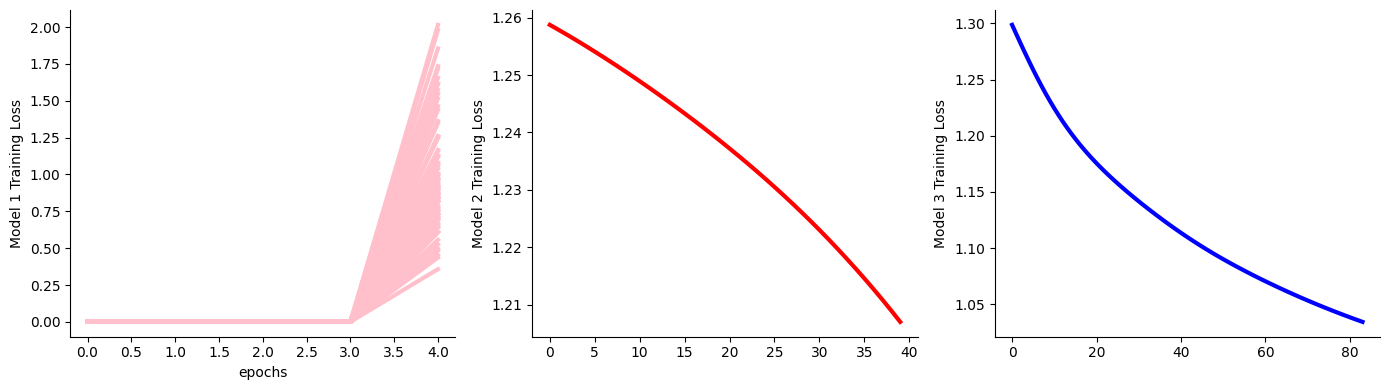

In [11]:
# Training Loss Visualization

plt.figure(figsize = (14, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss1, linewidth = 3, color = 'pink')
plt.ylabel("Model 1 Training Loss")
plt.xlabel("epochs")
sns.despine()

plt.subplot(1, 3, 2)
plt.plot(train_loss2, linewidth = 3, color = 'red')
plt.ylabel("Model 2 Training Loss")
sns.despine()

plt.subplot(1, 3, 3)
plt.plot(train_loss3, linewidth = 3, color = 'blue')
plt.ylabel("Model 3 Training Loss")
sns.despine()

plt.tight_layout()
plt.show()

In [12]:
#Testing Loss Computation

with torch.no_grad():

        test_outputs1 = model1(test_features)
        test_loss1 = loss_func(test_outputs1, test_targets) 
        print(f'Model 1 Testing MSE Error: '+str(test_loss1.numpy()))

        test_outputs2 = model2(test_features)
        test_loss2 = loss_func(test_outputs2, test_targets) 
        print(f'Model 2 Testing MSE Error: '+str(test_loss2.numpy()))

        test_outputs3 = model3(test_features)
        test_loss3 = loss_func(test_outputs3, test_targets) 
        print(f'Model 3 Testing MSE Error: '+str(test_loss3.numpy()))

Model 1 Testing MSE Error: 1.2474504
Model 2 Testing MSE Error: 1.2946823
Model 3 Testing MSE Error: 1.086927


In [13]:
#Scaling Back the data

test1_inv = np.around(scaler.inverse_transform(test_outputs1))
test2_inv = np.around(scaler.inverse_transform(test_outputs2))
test3_inv = np.around(scaler.inverse_transform(test_outputs3))
test_inv = np.around(scaler.inverse_transform(test_targets))

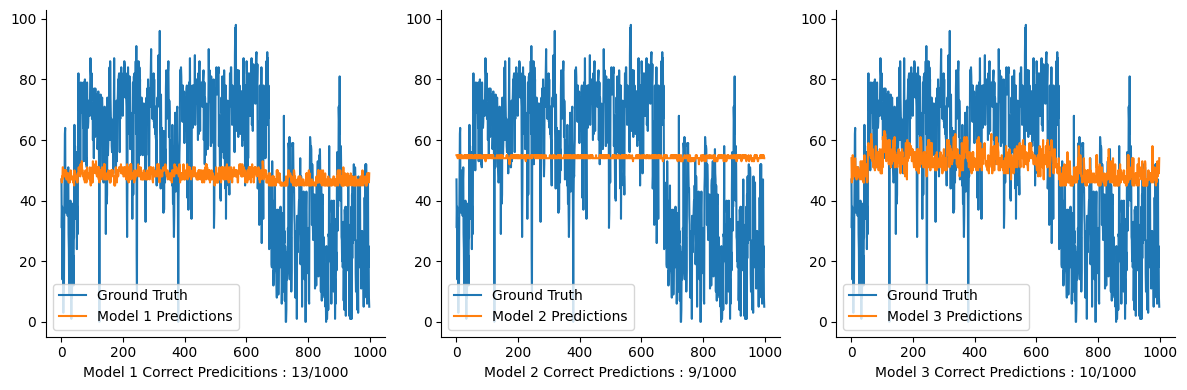

In [14]:
#Testing Accuracy

#Correct Predictions

n1 = 0
n2 = 0
n3 = 0

for i in range(test_inv.shape[0]):
    if test_inv[i] == test1_inv[i]:
        n1 += 1
    elif test_inv[i] == test2_inv[i]:  
        n2 += 1
    elif test_inv[i] == test3_inv[i]:
        n3 += 1

#Visualization
plt.figure(figsize = (12, 4))

plt.subplot(1,3,1)
plt.plot(test_inv, label='Ground Truth')
plt.plot(test1_inv, label='Model 1 Predictions')
plt.xlabel('Model 1 Correct Predicitions : '+str(n1)+'/1000')
plt.legend()
sns.despine()

plt.subplot(1,3,2)
plt.plot(test_inv, label='Ground Truth')
plt.plot(test2_inv, label='Model 2 Predictions')
plt.xlabel('Model 2 Correct Predictions : '+str(n2)+'/1000')
plt.legend()
sns.despine()

plt.subplot(1,3,3)
plt.plot(test_inv, label='Ground Truth')
plt.plot(test3_inv, label='Model 3 Predictions')
plt.xlabel('Model 3 Correct Predictions : '+str(n3)+'/1000')
plt.legend()
sns.despine()

plt.tight_layout()
plt.show()  

In [15]:
#Model Saving

torch.save({
            'model1_state_dict': model1.state_dict(),
            'model2_state_dict': model2.state_dict(),
            'model3_state_dict': model3.state_dict(),
            'optimizer1_state_dict': optimizer1.state_dict(),
            'optimizer2_state_dict': optimizer2.state_dict(),
            'optimizer3_state_dict': optimizer3.state_dict(),
            },'../checkpoint/models.tar' )

testing = np.save('../demo/spotify_testing_data',test_features)